##### Copyright 2018 The TF-Agents Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# REINFORCE エージェント

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/agents/tutorials/6_reinforce_tutorial"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.orgで表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/agents/tutorials/6_reinforce_tutorial.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/agents/tutorials/6_reinforce_tutorial.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示{</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/agents/tutorials/6_reinforce_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード/a0}</a></td>
</table>

## はじめに

この例は、<a>DQN チュートリアル</a>のように、Cartpole 環境で TF-Agents ライブラリを使用して [REINFORCE（強化）](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)エージェントをトレーニングする方法を示します。

![Cartpole environment](https://github.com/tensorflow/docs-l10n/blob/master/site/en-snapshot/agents/tutorials/images/cartpole.png?raw=true)

ここでは、トレーニング、評価、データ収集に使用する強化学習（RL）パイプラインの全コンポーネントについて説明します。


## セットアップ

以下の依存関係をインストールしていない場合は、実行します。

In [2]:
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -q tf-agents



ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).


The following packages were automatically installed and are no longer required:
  adwaita-icon-theme ca-certificates-java dconf-gsettings-backend
  dconf-service default-jre default-jre-headless dkms fonts-dejavu-extra
  freeglut3 freeglut3-dev g++-6 glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas gtk-update-icon-cache
  hicolor-icon-theme humanity-icon-theme java-common libaccinj64-9.1
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcairo-gobject2 libcolord2 libcudart9.1 libcufft9.1
  libcufftw9.1 libcups2 libcurand9.1 libcusolver9.1 libcusparse9.1 libdconf1
  libdrm-dev libegl-mesa0 libegl1 libegl1-mesa libepoxy0 libgbm1 libgif7
  libgl1-mesa-dev libgles1 libgles2 libglu1-mesa libglu1-mesa-dev
  libglvnd-core-dev libglvnd-dev libgtk-3-0 libgtk-3-common libgtk2.0-0
  libgtk2.0-common libice-dev libjansson4 libjson-glib-1.0-

0 upgraded, 0 newly installed, 0 to remove and 93 not upgraded.


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()


# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## ハイパーパラメータ

In [4]:
env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 250 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}

## 環境

強化学習の環境は、解決しようとしているタスクまたは問題を表しています。標準環境は、`suites`を使用して TF-Agent で簡単に作成できます。OpenAI Gym、Atari、DM Control などのソースから環境を読み込むには異なる`suites`を使用し、これには文字列の環境名が与えられます。

では、OpenAI Gym スイートから CartPole 環境を読み込みましょう。

In [5]:
env = suite_gym.load(env_name)

この環境をレンダリングして、どのように見えるかを確認できます。台車の上に回転軸を固定した棒を立て、その棒が倒れないように台車を左右に動かすことが目的です。

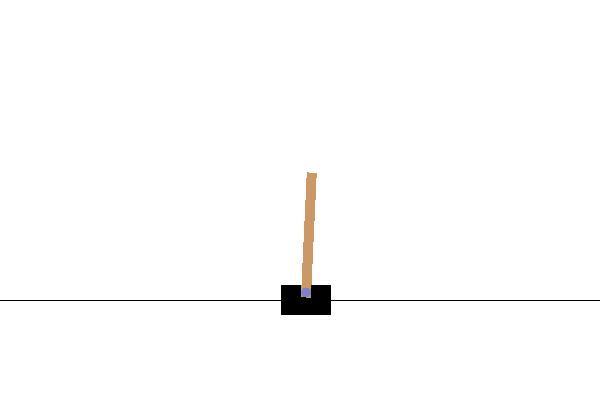

In [6]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

`time_step = environment.step(action)`文は環境で`action`を取ります。返される`TimeStep`タプルには、環境の次の観測とその行動の報酬を含みます。環境の`time_step_spec()`メソッドと`action_spec()`メソッドは、 `time_step`と`action`の仕様（タイプ、形状、境界）をそれぞれ返します。

In [7]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


つまり、観測は、台車の位置と速度、軸の角度位置と速度から成る 4 つの浮動小数点数の配列であることが分かります。2 つの行動（左に動かす、または右に動かす）のみが可能なので、`action_spec`はスカラーで、0 は「左に動かす」を意味し、1 は「右に移動する」を意味します。

In [8]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([0.0361198 , 0.02420668, 0.00372084, 0.04560814], dtype=float32))
Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.03660393,  0.21927509,  0.004633  , -0.2458985 ], dtype=float32))


通常は、トレーニング用と評価用の 2 つの環境を作成します。ほとんどの環境は純粋な python で記述されていますが、`TFPyEnvironment` ラッパーを使用すると容易に TensorFlow に変換できます。元の環境の API は numpy 配列を使用していますが、`TFPyEnvironment` はこれらを `Tensors` に変換したりその逆を可能にするので、より簡単に TensorFlow ポリシーやエージェントと相互作用できます。


In [9]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## 行動

強化学習問題の解決に使用するアルゴリズムは、`Agent`として表現されます。TF-Agents は、[DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)、[DDPG](https://arxiv.org/pdf/1509.02971.pdf)、[TD3](https://arxiv.org/pdf/1802.09477.pdf)、[PPO](https://arxiv.org/abs/1707.06347)、[SAC](https://arxiv.org/abs/1801.01290) などのさまざまな`Agents`の標準実装を提供します。

REINFORCE エージェントを作成するためには、まずは任意の環境の観測から行動の予測ができるように学習可能な`Actor Network`が必要です。

`Actor Network`は、観測と行動の仕様を使用して簡単に作成できます。ネットワーク内のレイヤーの指定が可能で、この例では`fc_layer_params`引数が各隠れレイヤーのサイズを表現する`ints`のタプルを設定しています（上記ハイパーパラメータのセクションをご覧ください）。


In [10]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

また、先ほど作成したネットワークをトレーニングする`optimizer` と、ネットワークが更新された回数を追跡する`train_step_counter`変数も必要です。


In [11]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

## ポリシー

TF-Agent では、ポリシーとは強化学習のポリシーの標準的な概念を表し、任意の`time_step`は行動または行動の分布を生成します。主なメソッドは`policy_step = policy.step(time_step)`で、`policy_step`は名前付きのタプル`PolicyStep(action, state, info)`です。`policy_step.action`は環境に適用される`action`で、`state`はステートフル（RNN）ポリシーの状態を表し、`info`には行動のログ確率などの補助情報が含まれる場合があります。

エージェントには、2 つのポリシーが含まれています。これは評価/デプロイに使用するメインのポリシー（agent.policy）と、データ収集に使用するもう 1 つのポリシー（agent.collect_policy）です。

In [12]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

## メトリクスと評価

ポリシーの評価に使用される最も一般的なメトリックは、平均リターンです。リターンは、エピソードの環境でポリシーを実行中に取得した報酬の合計であり、通常は複数のエピソード間で平均化します。平均リターンのメトリックは以下のように計算できます。


In [13]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# Please also see the metrics module for standard implementations of different
# metrics.

## 再生バッファ

環境から収集したデータを追跡するには、TFUniformReplayBuffer を使用します。この再生バッファは格納するテンソルを記述する仕様を使って構築され、`tf_agent.collect_data_spec`を使用してエージェントから取得することができます。

In [14]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

ほとんどのエージェントの場合、`collect_data_spec`は`Trajectory`という名前付きタプルであり、観測、行動、報酬、その他が含まれています。

## データ収集

REINFORCE はエピソード全体から学習するため、任意のデータ収集ポリシーを使用してエピソードを収集する関数を定義し、データ（観測、行動、報酬など）を再生バッファに軌跡として保存します。

In [15]:
#@test {"skip": true}

def collect_episode(environment, policy, num_episodes):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1


# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

## エージェントのトレーニング

トレーニングループには、環境からのデータ収集とエージェントのネットワークの最適化の両方を含みます。途中でエージェントのポリシーを時々評価して、状況を確認します。

以下の実行には 3 分ほどかかります。

In [16]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


step = 25: loss = -0.5438544750213623


step = 50: loss = -0.23360729217529297


step = 50: Average Return = 104.5999984741211


step = 75: loss = 0.1887521743774414


step = 100: loss = -1.5150158405303955


step = 100: Average Return = 124.69999694824219


step = 125: loss = 0.11275577545166016


step = 150: loss = 0.3582572937011719


step = 150: Average Return = 200.0


step = 175: loss = 0.5104646682739258


step = 200: loss = -0.6397652626037598


step = 200: Average Return = 200.0


step = 225: loss = -7.164270401000977


step = 250: loss = -0.45493757724761963


step = 250: Average Return = 200.0


## 視覚化


### プロット

リターンとグローバルステップをプロットして、エージェントのパフォーマンスを確認できます。`Cartpole-v0`では、棒が立ったままのタイムステップごとに環境は +1 の報酬を提供します。最大ステップ数は 200 であるため、可能な最大リターン値も 200 です。

(4.8050004005432125, 250.0)

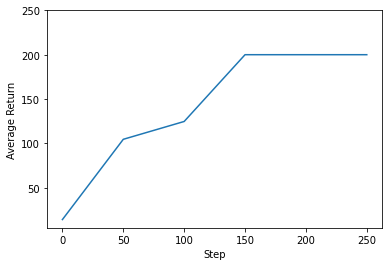

In [17]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

### 動画

各ステップで環境をレンダリングすると、エージェントのパフォーマンスを可視化できます。その前に、この Colab に動画を埋め込む関数を作成しましょう。

In [18]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

次のコードは、いくつかのエピソードに渡るエージェントのポリシーを可視化します。

In [19]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)